<a href="https://colab.research.google.com/github/odhrandooley/Met-Eireann/blob/main/Plot_Ballinasloe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing and Installing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install netcdf4

In [ ]:
!pip install pyproj

     |████████████████████████████████| 6.6MB 8.1MB/s 


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, ColorConverter
from osgeo import gdal
from pyproj import Proj

In [ ]:
lonmin=-11 #longitude minimale
latmax=56 # latitude maximum
lonmax=-4 #longitude maximum
latmin=50  #latitude minimal

In [ ]:
fncorine='/content/drive/MyDrive/CORINE/u2018_clc2018_v2020_20u1_raster100m/DATA/U2018_CLC2018_V2020_20u1.tif'
res=10 # Sentinel files resolution
src_fn=fncorine
out_fn='CORINEcut10m.tif' # 10m cutted filename
ds=gdal.Open(src_fn)
gdal.Translate(out_fn,ds,projWin = [lonmin, latmax, lonmax, latmin],projWinSRS='EPSG:4326',xRes=res,yRes=res) #10 by 10 resolution, lat lon rectangle

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f895425c420> >

In [ ]:
projection='EPSG:4326' # EPSG code for lat/lon
file10m='CORINEcut10m.tif'
out_fn='CORINE10mlatlon.tif'
ds=gdal.Open(file10m)
gdal.Warp(out_fn,ds,dstSRS=projection)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f896dd22510> >

In [ ]:
#!gdal.info $out_fn

In [ ]:
def get_data(fname,latmax,latmin,lonmax,lonmin):

    gdal.UseExceptions()
    ds = gdal.Open(fname)
    data = ds.ReadAsArray()
    gt = ds.GetGeoTransform()
    #
    #
    #
    xres = gt[1]
    yres = gt[5]
    #
    xmin = gt[0]
    ymin = gt[3]
    #
    xmax = gt[0] + (xres * ds.RasterXSize)
    ymax = gt[3] + (yres * ds.RasterYSize)
#    else:
#        xmax = gt[0] + (xres * ds.RasterXSize) 
#        ymax = gt[3] + (yres * ds.RasterYSize) 


    X=np.arange(xmin+xres,xmax+xres,xres)
    Y=np.arange(ymin+yres,ymax+yres,yres)


    #Chunck the data to save RAM for plotting
    #Ydecreasing
    b=np.min(np.where(Y<latmin)[0])
    a=np.max(np.where(Y>latmax)[0])

    c=np.max(np.where(X<lonmin)[0])
    d=np.min(np.where(X>lonmax)[0])

#    print(np.max(data))
#    print(np.min(data))
    #ECOCLIMAP data have no projections so no need to reproject the data
    #to be verified for other datasets
    LAT=Y[a:b]
    LON=X[c:d]
    D=data[a:b,c:d]

    return (LAT,LON,D)

In [ ]:
def read_legend_file(file_legend):
  data=open(file_legend)
  text=[t for t in data]
  covernum=[int(d.split(',')[0]) for d in text]
  colors=[tuple((int(d.split(',')[1])/255.0,int(d.split(',')[2])/255.0,int(d.split(',')[3])/255.0,int(d.split(',')[4])/255.0)) for d in text]
  covername=[d.split(',')[5] for d in text]
  return(data,text,covernum,colors,covername)

In [ ]:
def corinecolormap(colors):
  c=ColorConverter().to_rgb
  rgbc=[c(col) for col in colors]
  newcmap=ListedColormap(rgbc)
  return(newcmap)
  

In [ ]:
#Converts the dataset to covername list index then Dplot=0 correspond to covername[0] ... Dplot[44] correspond to covername[44] 
# It is just easier to plot
def Adjustdatasetforploting(D,covernum):
  Dplot=D
  for i,fv in enumerate(covernum):
      Dplot[np.where(D==fv)]=i
  Dplot[Dplot==128]=44 ### put the no data values (128) to 44 (sea and ocean)
  return Dplot

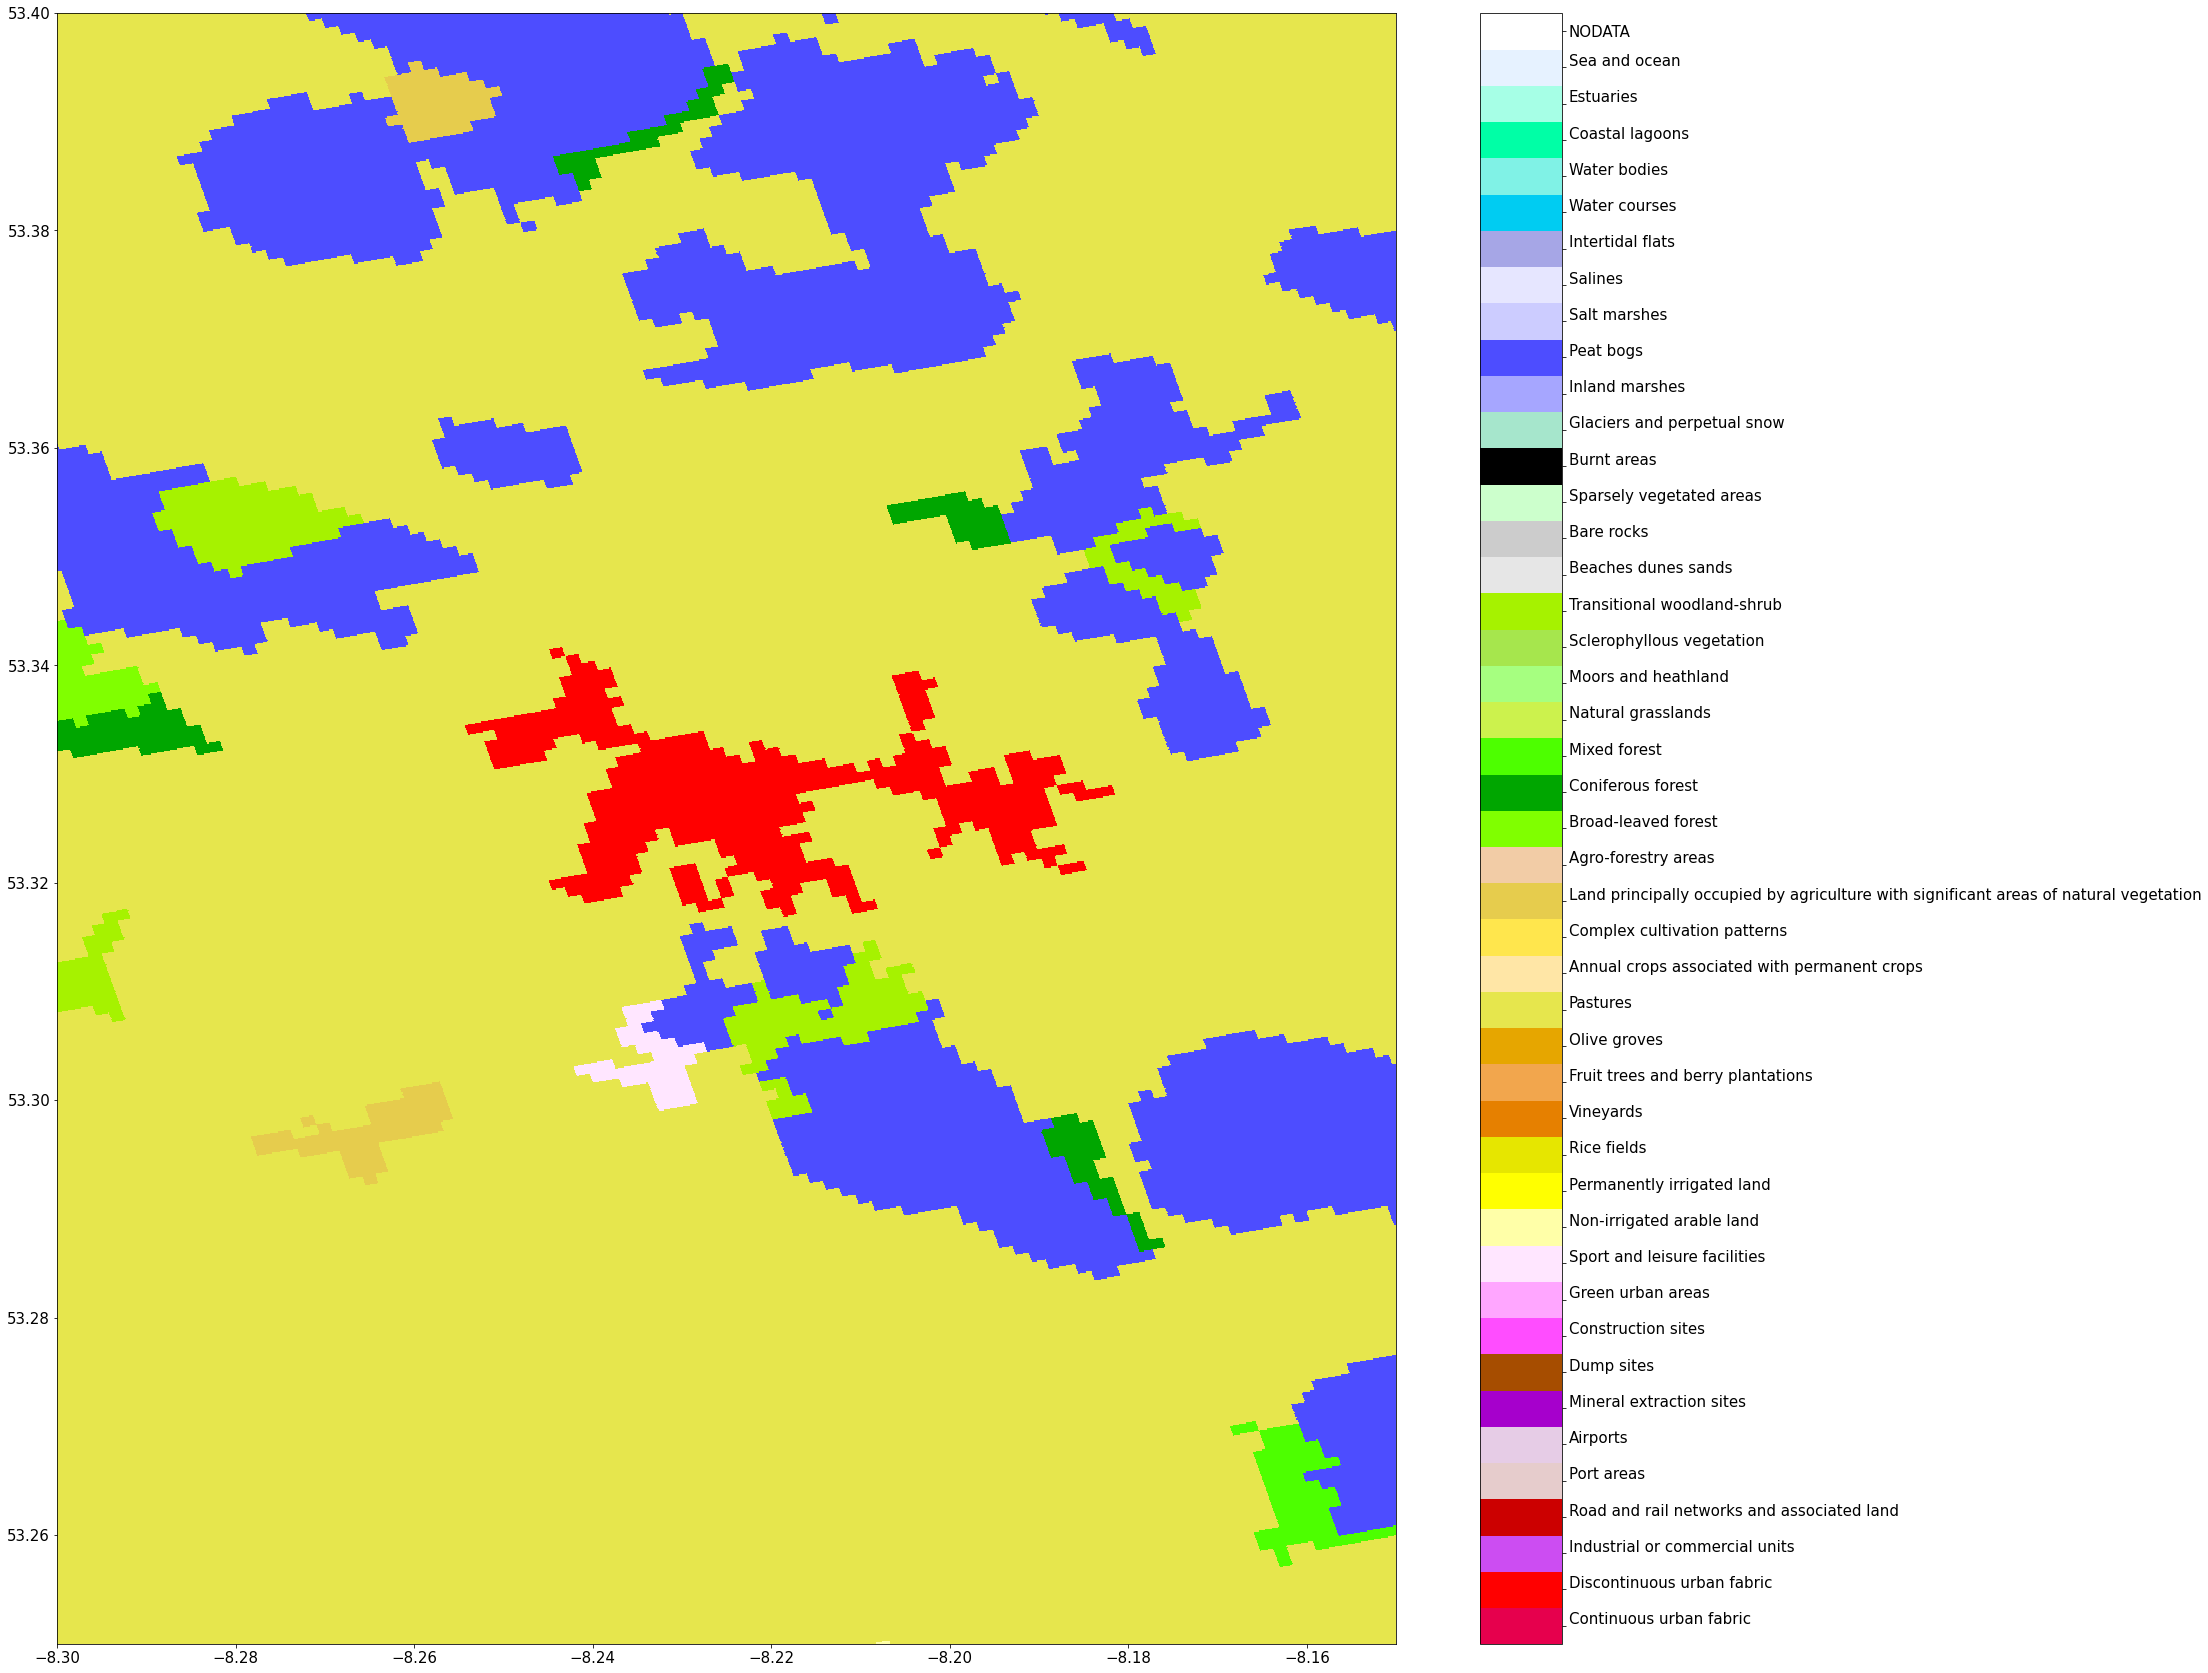

In [ ]:
#For Ballinasloe
#notes, no river!

latmax=53.4
latmin=53.25
lonmax=-8.15
lonmin=-8.3
fname='CORINE10mlatlon.tif'

(LAT,LON,D) = get_data(fname,latmax,latmin,lonmax,lonmin)

file_legend='/content/drive/MyDrive/CORINE/u2018_clc2018_v2020_20u1_raster100m/Legend/CLC2018_CLC2018_V2018_20_QGIS.txt'
(data,text,covernum,colors,covername)=read_legend_file(file_legend)
# Adjust the dataset for easier plotting
Dplot=Adjustdatasetforploting(D,covernum)
# Create the colormap
newcmap=corinecolormap(colors)

fig, axs = plt.subplots(1, 1,figsize=(30, 30))
ax1=axs
LONg, LATg = np.meshgrid(LON, LAT)
c=ax1.pcolormesh(LONg,LATg,Dplot-1,cmap=newcmap,vmin=0,vmax=len(covernum))
ax1.set_xlim(lonmin,lonmax)
ax1.set_ylim(latmin,latmax)
cb=plt.colorbar(c, ax=ax1, ticks=np.arange(0.5,len(covernum)),extendfrac='auto', spacing='proportional')   
cb.set_ticklabels(covername)
cb.ax.tick_params(labelsize=15)
ax1.tick_params(labelsize=15)
fig.savefig('CORINE_plot.png',format='png',quality=95,bbox_inches='tight')

In [ ]:
covername

['Continuous urban fabric\n',
 'Discontinuous urban fabric\n',
 'Industrial or commercial units\n',
 'Road and rail networks and associated land\n',
 'Port areas\n',
 'Airports\n',
 'Mineral extraction sites\n',
 'Dump sites\n',
 'Construction sites\n',
 'Green urban areas\n',
 'Sport and leisure facilities\n',
 'Non-irrigated arable land\n',
 'Permanently irrigated land\n',
 'Rice fields\n',
 'Vineyards\n',
 'Fruit trees and berry plantations\n',
 'Olive groves\n',
 'Pastures\n',
 'Annual crops associated with permanent crops\n',
 'Complex cultivation patterns\n',
 'Land principally occupied by agriculture with significant areas of natural vegetation\n',
 'Agro-forestry areas\n',
 'Broad-leaved forest\n',
 'Coniferous forest\n',
 'Mixed forest\n',
 'Natural grasslands\n',
 'Moors and heathland\n',
 'Sclerophyllous vegetation\n',
 'Transitional woodland-shrub\n',
 'Beaches dunes sands\n',
 'Bare rocks\n',
 'Sparsely vegetated areas\n',
 'Burnt areas\n',
 'Glaciers and perpetual snow\n'

In [ ]:
def cover_fraction(filename):
    data=open(filename)
    covernum=[]
    covername=[]
    cityfrac=[]
    vegfrac=[]
    inwaterfrac=[]
    seafrac=[]
    for i,d in enumerate(data):
        if i==0:
            fieldnames=d.split(',')
            covername.append('no data')
            cityfrac.append(0.0)
            vegfrac.append(0.0)
            inwaterfrac.append(0.0)
            seafrac.append(0.0)
        else:
#            print(d.split(','))
            covernum.append(int(d.split(',')[0]))
            covername.append(d.split(',')[1])
            cityfrac.append(float(d.split(',')[2]))
            vegfrac.append(float(d.split(',')[3]))
            inwaterfrac.append(float(d.split(',')[4]))
            seafrac.append(float(d.split(',')[5]))
    return(fieldnames,np.array(covernum),covername,np.array(cityfrac),np.array(vegfrac),
           np.array(inwaterfrac),np.array(seafrac))

In [ ]:
c0=(0/255.0,0/255.0,0/255.0,255/255.0)## 0 value
c1=(0/255.0,0/255.0,128/255.0,255/255.0)##navy blue 1.sea    
c2=(0/255.0,0/255.0,205/255.0,255/255.0)## mediumblue 2.inland waters
c3=(0/255.0, 0/255.0, 255/255.0, 255/255.0) ##Blue 3.rivers
c4=(211/255.0,211/255.0,211/255.0,255/255.0)## lightgray 4.Bare land
c5=(169/255.0,169/255.0,169/255.0,255/255.0)## darkgray 5.Rocks
c6=(255/255.0,250/255.0,250/255.0,255/255.0) ## Snow 6.permanent snow
c7=(240/255.0,255/255.0,240/255.0,255/255.0)## Honeydew 7.boreal broadleaf deciduous
c8=(85/255.0,107/255.0,47/255.0,255/255.0)## darkolivegreen 8.temperate broadleaf deciduous
c9=(154/255.0,205/255.0,50/255.0,255/255.0)## yellowgreen 9.tropical broadleaf deciduous
c10=(0/255.0,128/255.0,0/255.0,255/255.0)## green 10.temperate broadleaf evergreen
c11=(255/255.0,127/255.0,80/255.0,255/255.0)## coral 11. tropical broadleaf evergreen
c12=(160/255.0,82/255.0,45/255.0,255/255.0)## siena 12. boreal needleaf evergreen
c13=(34/255.0,139/255.0,34/255.0,255/255.0)## forest green 13.temperate needleleaf evergreen
c14= (188/255.0,143/255.0,143/255.0,255/255.0)## rosybrown 14. boreal needleleaf deciduous
c15=(205/255.0,133/255.0,63/255.0,255/255.0)## peru 15. shrubs
c16=(222/255.0,184/255.0,135/255.0,255/255.0)##  burlywood 16. boreal grassland
c17=(50/255.0,205/255.0,50/255.0,255/255.0)##limegreen 17 . temperate grassland
c18=(255/255.0,215/255.0,0/255.0,255/255.0) ##gold 18. tropical grassland
c19=(32/255.0,178/255.0,170/255.0,255/255.0)##lightseagreen 19.winter crop
c20=(173/255.0,255/255.0,47/255.0,255/255.0)##green yellow 20.summer crop
c21=(189/255.0,183/255.0,107/255.0,255/255.0)##darkkhaki 21. C4 crops
c22=(102/255.0,102/255.0,0/255.0,255/255.0)## Dark yellow3 22.flooded trees
c23=(46/255.0,139/255.0,87/255.0,255/255.0)## seagreen 23.flooded grassland
c24=(138/255.0,2/255.0,0/255.0,255/255.0)## 24. red LCZ1
c25=(206/255.0,0/255.0,0/255.0,255/255.0)## 25. red LCZ2
c26=(252/255.0,1/255.0,1/255.0,255/255.0)## 26. red LCZ3
c27=(255/255.0,90/255.0,0/255.0,255/255.0)## 27. red LCZ4
c28=(255/255.0,120/255.0,0/255.0,255/255.0)## 28. red LCZ5
c29=(255/255.0,150/255.0,0/255.0,255/255.0)## 29. red LCZ6
c30=(255/255.0,180/255.0,0/255.0,255/255.0)## 30. red LCZ7
c31=(255/255.0,210/255.0,0/255.0,255/255.0)## 31.red LCZ8
c32=(255/255.0,240/255.0,0/255.0,255/255.0)## 32. red LCZ9
c33=(128/255.0,128/255.0,128/255.0,255/255.0)## 33. gray LCZ10
scheme=[c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24,c25,c26,c27,c28,c29,c30,c31,c32,c33]
colSG = ListedColormap(scheme)

In [ ]:
def get_dataSG(fname,latmax,latmin,lonmax,lonmin):

    gdal.UseExceptions()
    dinputf = gdal.Open(fname)
    output='tempSG.tif'    
    gdal.Translate(output,dinputf,projWin=[lonmin,latmax,lonmax,latmin])
    ds=gdal.Open(output)
    data = ds.ReadAsArray()
    gt = ds.GetGeoTransform()
    #
    #
    #
    xres = gt[1]
    yres = gt[5]
    #
    xmin = gt[0]
    ymin = gt[3]
    #
    xmax = gt[0] + (xres * ds.RasterXSize)
    ymax = gt[3] + (yres * ds.RasterYSize)
#    else:
#        xmax = gt[0] + (xres * ds.RasterXSize) 
#        ymax = gt[3] + (yres * ds.RasterYSize) 


    X=np.arange(xmin+xres,xmax+xres,xres)
    Y=np.arange(ymin+yres,ymax+yres,yres)


    #Chunck the data to save RAM for plotting
    #Ydecreasing
    #b=np.min(np.where(Y<latmin)[0])
    #a=np.max(np.where(Y>latmax)[0])

    #c=np.max(np.where(X<lonmin)[0])
    #d=np.min(np.where(X>lonmax)[0])

#    print(np.max(data))
#    print(np.min(data))
    #ECOCLIMAP data have no projections so no need to reproject the data
    #to be verified for other datasets
    LAT=Y
    LON=X
    D=data

    return (LAT,LON,D)


In [ ]:
def plotECOSG(fnameSG,covernamef,centerlat,centerlon,plotextentx,plotextenty,
              savefile_suffix,fsize=(30,30)):
      latmin=centerlat-plotextenty
      latmax=centerlat+plotextenty
      lonmin=centerlon-plotextentx
      lonmax=centerlon+plotextentx
      (LATSG,LONSG,DSG)=get_dataSG(fnameSG,latmax+0.1,latmin-0.1,lonmax+0.1,lonmin-0.1) # the 0.1 is just to cover the projection reshaping
      (fieldnames,covernum,covername,cityfrac,vegfrac,inwaterfrac,seafrac)=cover_fraction(covernamef)
      fig, axs = plt.subplots(4, 1,figsize=fsize)
      ax1=axs[0]
      LONg, LATg = np.meshgrid(LONSG,LATSG)
      c=ax1.pcolormesh(LONSG,LATSG,DSG,cmap=colSG, vmin=0,vmax=len(covername))
      ax1.set_xlim(lonmin,lonmax)
      ax1.set_ylim(latmin,latmax)
      cb=plt.colorbar(c, ax=ax1, ticks=np.arange(0.5,len(covername)+0.5),extendfrac='auto', spacing='proportional',pad=0.003)   
      cb.set_ticklabels(covername)
      cb.ax.tick_params(labelsize=35)
      ax1.tick_params(labelsize=35)
      fig.savefig(savefile_suffix+'ecosg.png',format='png',quality=95,bbox_inches='tight')

In [ ]:
def getcenterandextentinlatlon(ulx,uly,extent,projection='EPSG:32629'):
    lrx=ulx+extent
    lry=uly-extent
    cx=ulx+extent*0.5
    cy=uly-extent*0.5
    p=Proj(projection)
    ULX,ULY=p(ulx,uly, inverse=True)
    LRX,LRY=p(lrx,lry, inverse=True)
    CX,CY=p(cx,cy, inverse=True)
    extentx=LRX-CX
    extenty=CY-LRY
    return(CX,CY,extentx,extenty)

In [ ]:
fnameSG='/content/drive/MyDrive/ECOCLIMAP_SG/ecosg_final_map.dir' #ecosg filename
covernamef='/content/drive/MyDrive/ECOCLIMAP_SG/ECOCLIMAP_SG_cover_data.csv' #file with all the cover name

<Figure size 2160x4320 with 0 Axes>

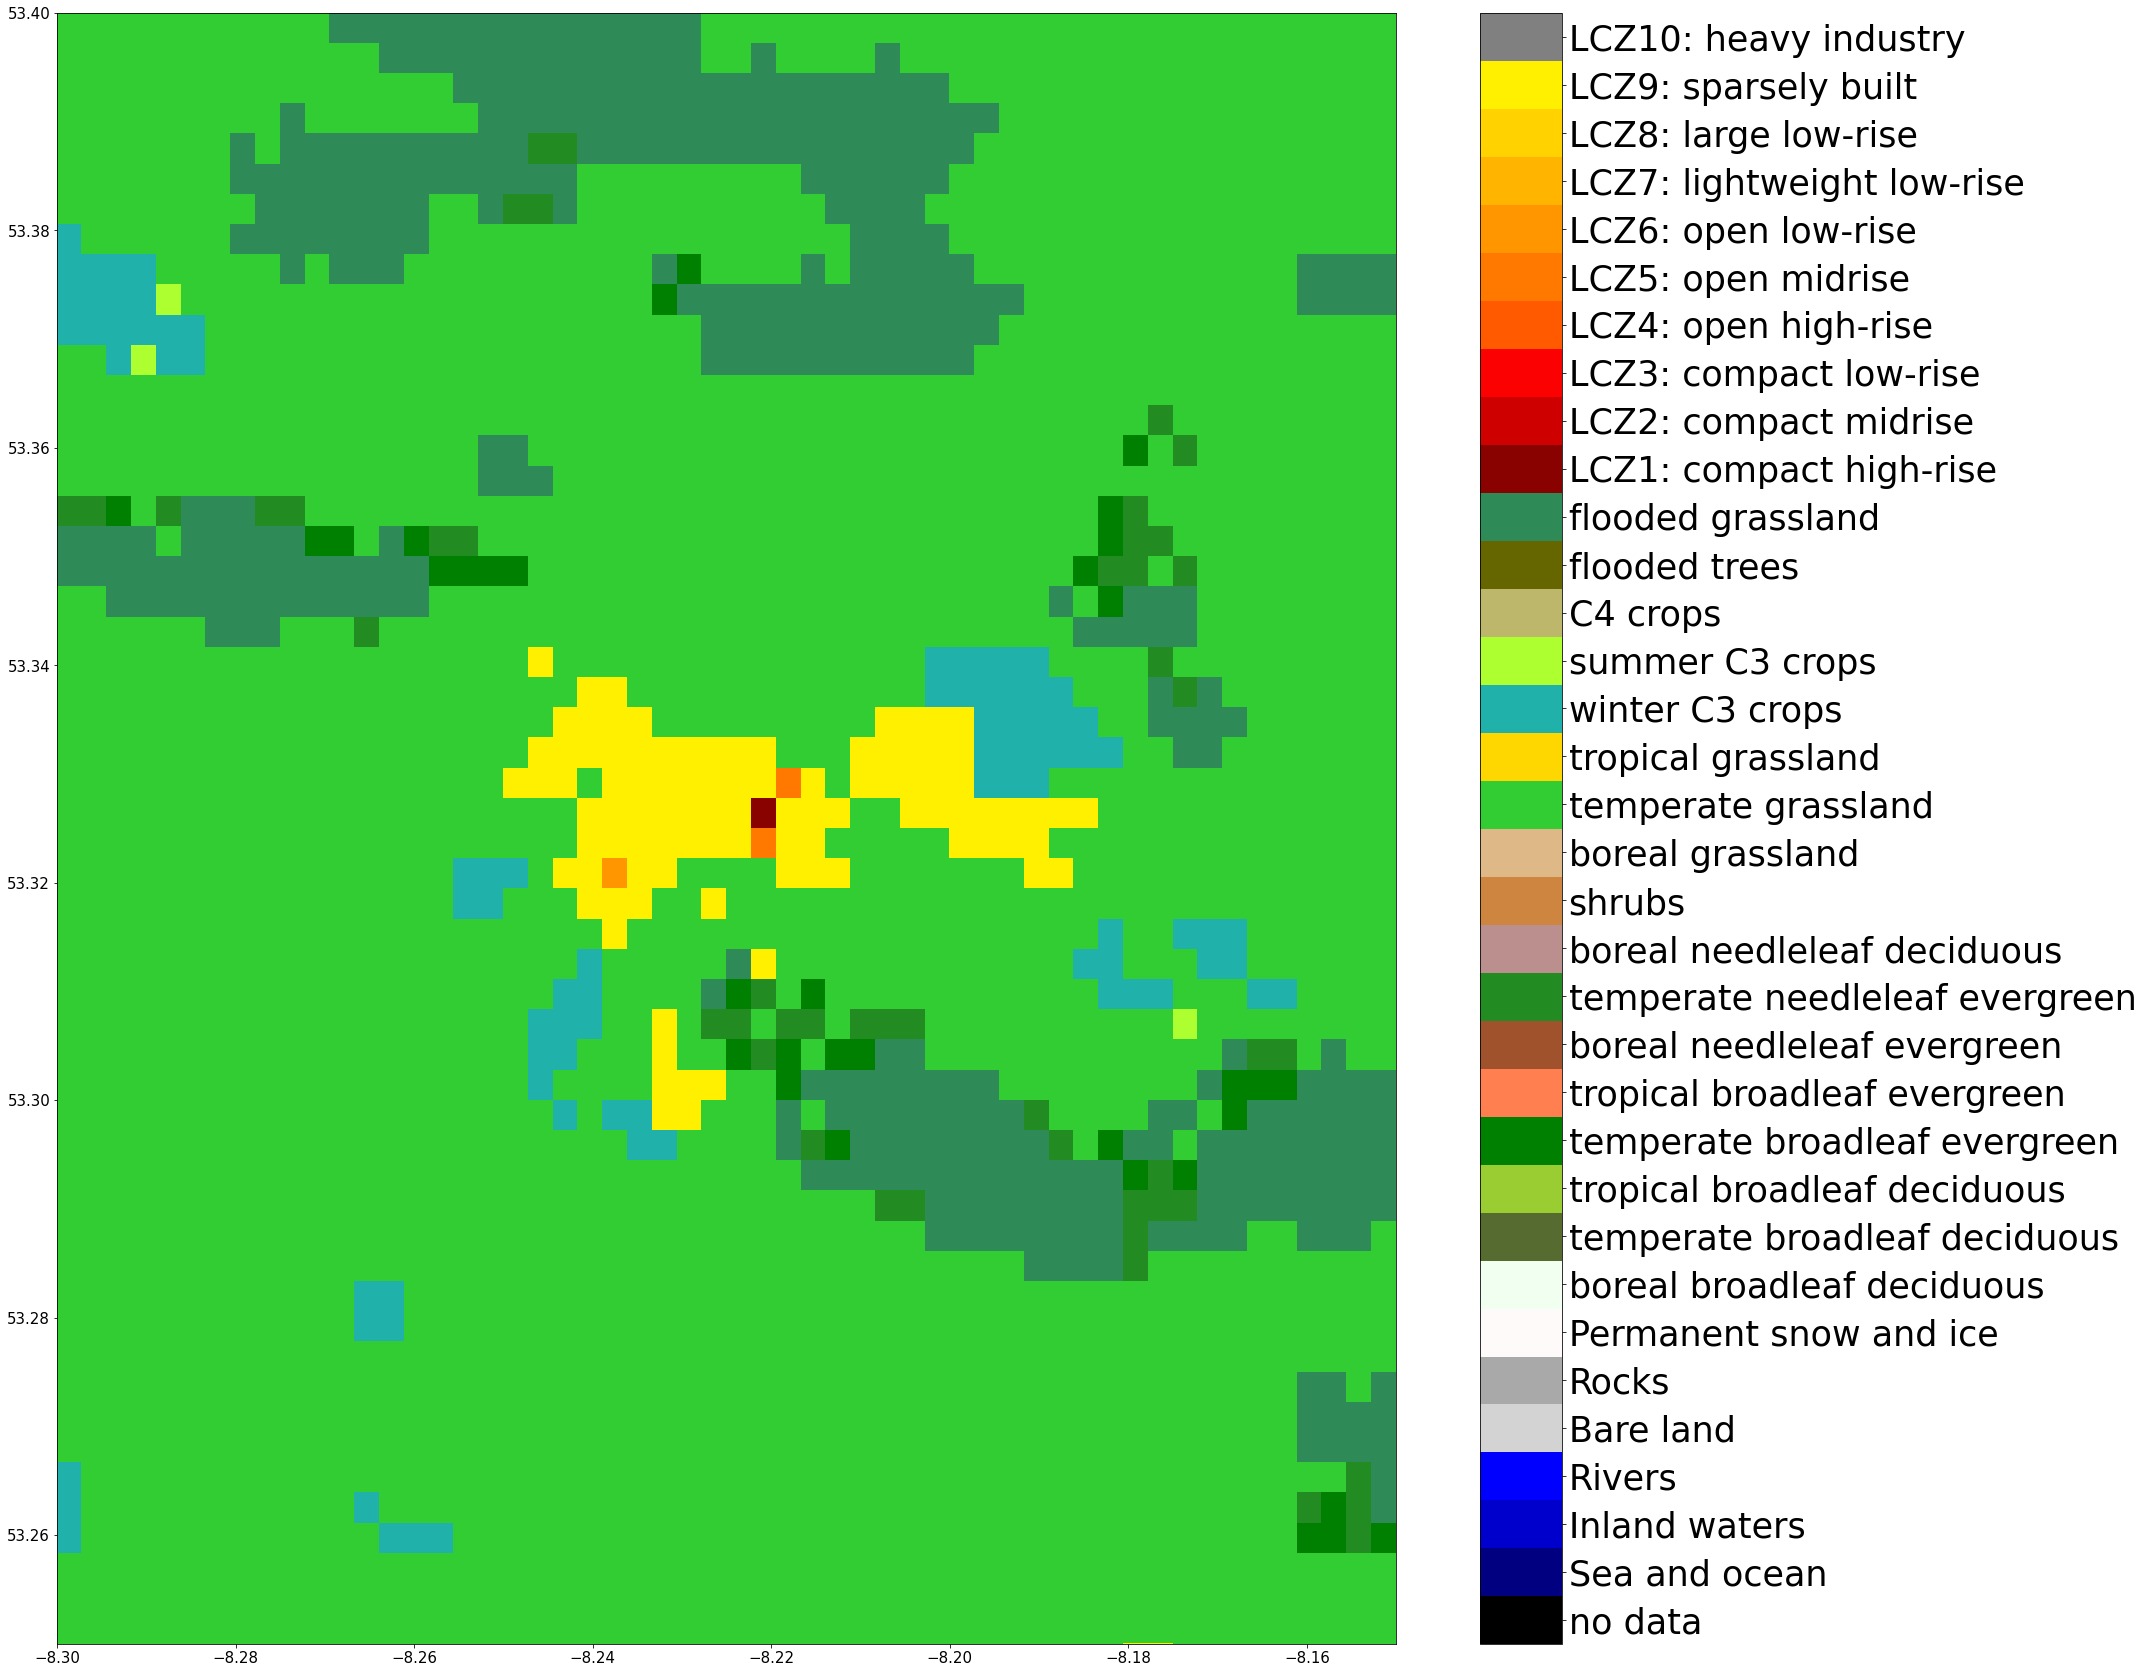

In [ ]:
savefile_suffix='ECOSG'
(fieldnames,covernum,covername,cityfrac,vegfrac,inwaterfrac,seafrac)=cover_fraction(covernamef)
fig=plt.figure(figsize=(30,60))
grid = plt.GridSpec(4, 2, hspace=0.25, wspace=0.25)
#fig, axs = plt.subplots(4, 1,figsize=(30,30))

# Ballinasloe


latmax=53.4
latmin=53.25
lonmax=-8.15
lonmin=-8.3

(LATSG,LONSG,DSG)=get_dataSG(fnameSG,latmax+0.1,latmin-0.1,lonmax+0.1,lonmin-0.1) # the 0.1 is just to cover the projection reshaping

fig, axs = plt.subplots(1, 1,figsize=(30, 30))
ax0=axs

#ax0=fig.add_subplot(grid[0, 0],adjustable='box',aspect=(lonmin-lonmax)/((latmin-latmax)))
LONg, LATg = np.meshgrid(LONSG,LATSG)
c=ax0.pcolormesh(LONSG,LATSG,DSG,cmap=colSG, vmin=0,vmax=len(covername))
ax0.set_xlim(lonmin,lonmax)
ax0.set_ylim(latmin,latmax)

cb=fig.colorbar(c, ax=ax0 , ticks=np.arange(0.5,len(covername)+0.5))   
cb.set_ticklabels(covername)
cb.ax.tick_params(labelsize=35)
ax0.tick_params(labelsize=15)
fig.savefig(savefile_suffix+'ecosg.png',format='png',quality=95,bbox_inches='tight')




# Primary

Convert Corine and ECOSG to Primary Corine

In [ ]:
def GiveArray(fnameSG,covernamef,centerlat,centerlon,plotextentx,plotextenty):
      latmin=centerlat-plotextenty
      latmax=centerlat+plotextenty
      lonmin=centerlon-plotextentx
      lonmax=centerlon+plotextentx
      (LATSG,LONSG,DSG)=get_dataSG(fnameSG,latmax+0.1,latmin-0.1,lonmax+0.1,lonmin-0.1)

      return DSG

In [ ]:
#to do : translate from ECOSG to primary CORINE and plot
def ECOtoPrimary(array):
  for i in range(0, len(array)):
    for j in range(0,len(array[0])):
      if array[i,j] == 0:
        array[i,j] = 0 #no data
      if array[i,j] >0 and array[i,j] <=3:
        array[i,j] = 1 #water
      if array[i,j] >3 and array[i,j] <=18:
        array[i,j] = 2 #nature
      if array[i,j] >18 and array[i,j] <=21:
        array[i,j] = 3  #agri    
      if array[i,j] == 22 or array[i,j] == 23:
        array[i,j] = 4  #wetlands
      if array[i,j] >23 and array[i,j] <=33:
        array[i,j] = 5  #urban
  return array

In [ ]:
PrimeCover = ['NoData','Water','Nature','Agriculture','Wetlands','Urban']

In [ ]:
c0=(0/255.0,0/255.0,0/255.0,255/255.0)## 0 no value
c1=(0/255.0,0/255.0,128/255.0,255/255.0)##navy blue 1. water
c2=(50/255.0,205/255.0,50/255.0,255/255.0)##limegreen 2. nature
c3=(255/255.0,250/255.0,250/255.0,255/255.0) ## Snow 3 agri
c4=(189/255.0,183/255.0,107/255.0,255/255.0)##darkkhaki 4 wetlands
c5=(138/255.0,2/255.0,0/255.0,255/255.0)## red 5 urban

scheme=[c0,c1,c2,c3,c4,c5]
colCOR = ListedColormap(scheme)

<Figure size 2160x4320 with 0 Axes>

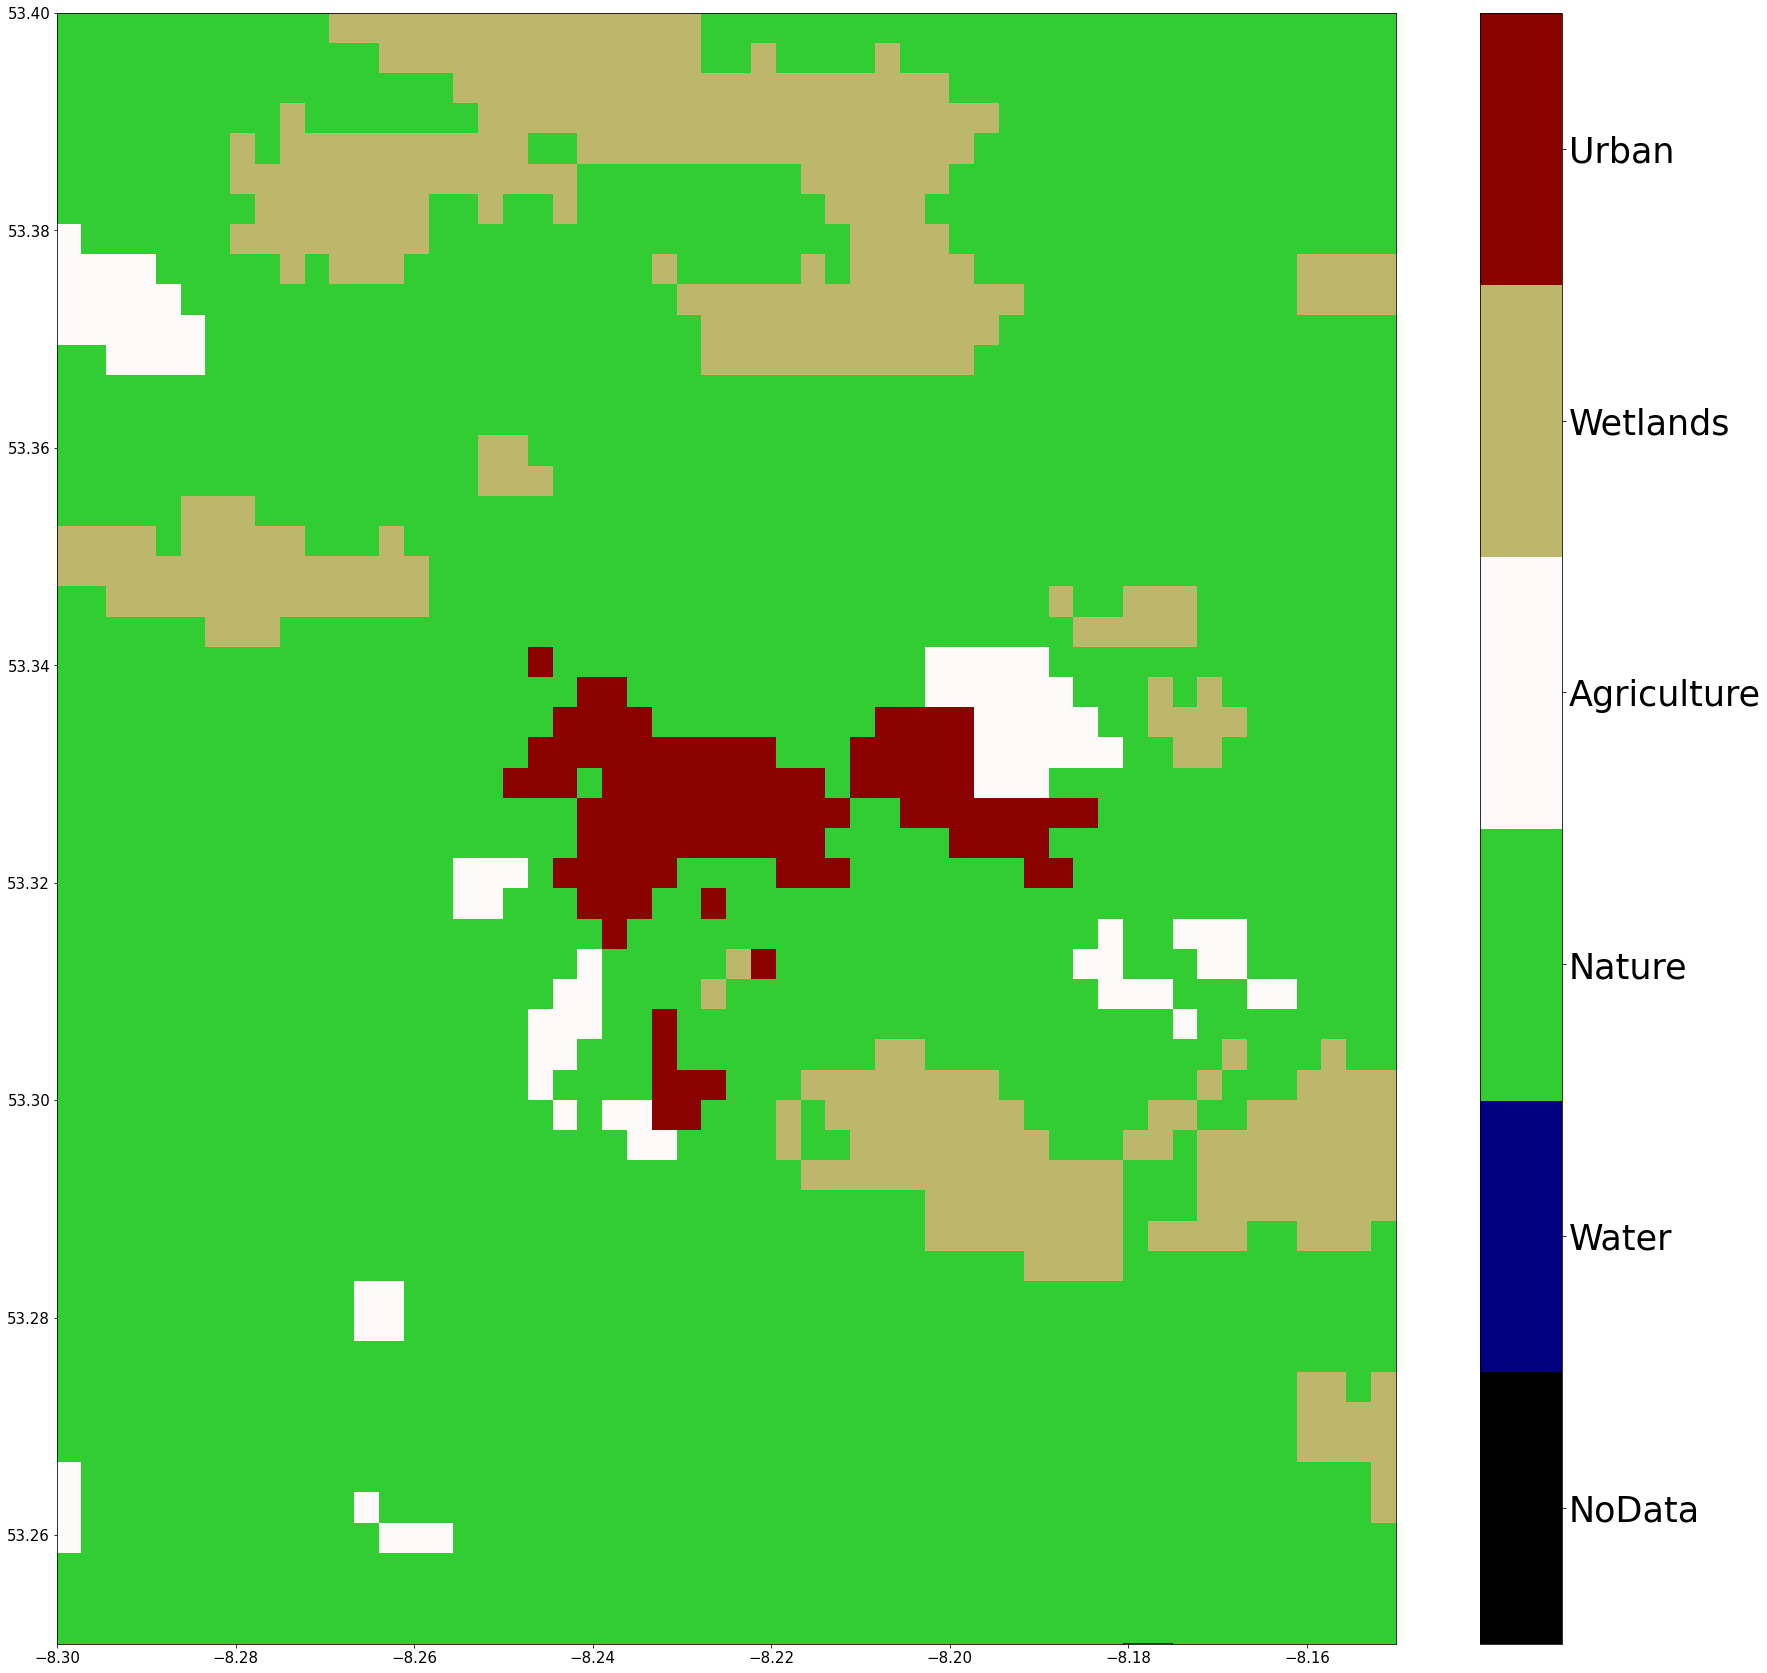

In [ ]:
savefile_suffix='ECOSG'
(fieldnames,covernum,covername,cityfrac,vegfrac,inwaterfrac,seafrac)=cover_fraction(covernamef)
fig=plt.figure(figsize=(30,60))
grid = plt.GridSpec(4, 2, hspace=0.25, wspace=0.25)
#fig, axs = plt.subplots(4, 1,figsize=(30,30))

# Ballinasloe


latmax=53.4
latmin=53.25
lonmax=-8.15
lonmin=-8.3

(LATSG,LONSG,D)=get_dataSG(fnameSG,latmax+0.1,latmin-0.1,lonmax+0.1,lonmin-0.1) # the 0.1 is just to cover the projection reshaping

DSG = ECOtoPrimary(D)

fig, axs = plt.subplots(1, 1,figsize=(30, 30))
ax0=axs

#ax0=fig.add_subplot(grid[0, 0],adjustable='box',aspect=(lonmin-lonmax)/((latmin-latmax)))
LONg, LATg = np.meshgrid(LONSG,LATSG)
c=ax0.pcolormesh(LONSG,LATSG,DSG,cmap=colCOR, vmin=0,vmax=len(PrimeCover))
ax0.set_xlim(lonmin,lonmax)
ax0.set_ylim(latmin,latmax)

cb=fig.colorbar(c, ax=ax0 , ticks=np.arange(0.5,len(PrimeCover)+0.5))   
cb.set_ticklabels(PrimeCover)
cb.ax.tick_params(labelsize=35)
ax0.tick_params(labelsize=15)
fig.savefig(savefile_suffix+'ecosg.png',format='png',quality=95,bbox_inches='tight')



In [ ]:
(data,text,covernum,colors,covername)=read_legend_file(file_legend)


In [ ]:
covernum

[111,
 112,
 121,
 122,
 123,
 124,
 131,
 132,
 133,
 141,
 142,
 211,
 212,
 213,
 221,
 222,
 223,
 231,
 241,
 242,
 243,
 244,
 311,
 312,
 313,
 321,
 322,
 323,
 324,
 331,
 332,
 333,
 334,
 335,
 411,
 412,
 421,
 422,
 423,
 511,
 512,
 521,
 522,
 523,
 999]

In [ ]:
lonmin=-11 #longitude minimale
latmax=56 # latitude maximum
lonmax=-4 #longitude maximum
latmin=50  #latitude minimal

fncorine='/content/drive/MyDrive/CORINE/u2018_clc2018_v2020_20u1_raster100m/DATA/U2018_CLC2018_V2020_20u1.tif'
res=10 # Sentinel files resolution
src_fn=fncorine
out_fn='CORINEcut10m.tif' # 10m cutted filename
ds=gdal.Open(src_fn)
gdal.Translate(out_fn,ds,projWin = [lonmin, latmax, lonmax, latmin],projWinSRS='EPSG:4326',xRes=res,yRes=res) #10 by 10 resolution, lat lon rectangle

projection='EPSG:4326' # EPSG code for lat/lon
file10m='CORINEcut10m.tif'
out_fn='CORINE10mlatlon.tif'
ds=gdal.Open(file10m)
gdal.Warp(out_fn,ds,dstSRS=projection)

latmax=53.4
latmin=53.25
lonmax=-8.15
lonmin=-8.3
fname='CORINE10mlatlon.tif'

(LAT,LON,DCOR) = get_data(fname,latmax,latmin,lonmax,lonmin)


In [ ]:
CORtoPrimary(DCOR)

NameError: ignored

In [ ]:
def CORtoPrimary(array):
  for i in range(0, len(array)):
    for j in range(0,len(array[0])):
      if array[i,j] == 999:
        array[i,j] = 0 #no data
      if array[i,j] <999 and array[i,j] >500:
        array[i,j] = 1 #water
      if array[i,j] >400 and array[i,j] <500:
        array[i,j] = 4 #wetlands
      if array[i,j] >300 and array[i,j] <400:
        array[i,j] = 2  #Nature   
      if array[i,j] >100 and array[i,j] <200:
        array[i,j] = 5  #urban
      if array[i,j] >200 and array[i,j] <300:
        array[i,j] = 3  #agri
  return array

In [ ]:
#For Ballinasloe
#notes, no river!

latmax=53.4
latmin=53.25
lonmax=-8.15
lonmin=-8.3
fname='CORINE10mlatlon.tif'

(LAT,LON,DCOR) = get_data(fname,latmax,latmin,lonmax,lonmin)

D = CORtoPrimary(DCOR)
print(D)
file_legend='/content/drive/MyDrive/CORINE/u2018_clc2018_v2020_20u1_raster100m/Legend/CLC2018_CLC2018_V2018_20_QGIS.txt'

(data,text,covernum,colors,covername)=read_legend_file(file_legend)
# Adjust the dataset for easier plotting
#Dplot=Adjustdatasetforploting(D,covernum)
# Create the colormap
newcmap=corinecolormap(colors)

fig, axs = plt.subplots(1, 1,figsize=(30, 30))
ax1=axs
LONg, LATg = np.meshgrid(LON, LAT)
c=ax1.pcolormesh(LONg,LATg,Dplot-1,cmap=newcmap,vmin=0,vmax=len(covernum))
ax1.set_xlim(lonmin,lonmax)
ax1.set_ylim(latmin,latmax)
cb=plt.colorbar(c, ax=ax1, ticks=np.arange(0.5,len(covernum)),extendfrac='auto', spacing='proportional')   
cb.set_ticklabels(covername)
cb.ax.tick_params(labelsize=15)
ax1.tick_params(labelsize=15)
fig.savefig('CORINE_plot.png',format='png',quality=95,bbox_inches='tight')